# Imports

In [1]:
# pip install catboost 

In [2]:
# pip install scipy

In [3]:
from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [4]:
class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """Meant to encode time data with cycles (days of week, month...)"""
    def __init__(self, column_name, cycle_length):
        self.column_name = column_name
        self.cycle_length = cycle_length

    def fit(self, X, y=None):
        # No fitting needed, implemented for compatibility with sklearn's API
        return self

    def transform(self, X, y=None):
        # Apply cyclical encoding directly without needing to fit
        X = X.copy()
        values = X[self.column_name]
        # Create the cyclical features
        X[f'{self.column_name}_sin'] = np.sin(2 * np.pi * values / self.cycle_length)
        X[f'{self.column_name}_cos'] = np.cos(2 * np.pi * values / self.cycle_length)
        # Drop the original column
        X.drop(columns=[self.column_name], inplace=True)
        return X

    def get_feature_names_out(self, input_features=None):
        # Generate names for the output features
        return np.array(
          [f'{self.column_name}_sin', f'{self.column_name}_cos'], dtype=object
        )

# Data Loading

In [5]:
%%time
df = pd.read_csv("../cleaned_dataset.csv", index_col=0)

CPU times: total: 1.92 s
Wall time: 1.94 s


# Droping Useless Columns

In [6]:
df = df.drop(columns=['LoanNr_ChkDgt', 'Name'])
df = df.dropna()

# Separating Features and Target

In [7]:
X = df.copy()
y = X.pop("MIS_Status")

# Hold-Out

In [8]:
# Stratify with y by default
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.05,
                                                    stratify=y,
                                                    random_state=42)

# Model

## Preprocessing

In [9]:
# Splitting columns
# num_cols = ["Term", "NoEmp", "CreateJob", "RetainedJob",
num_cols = ["Term", "NoEmp", "CreateJob", "RetainedJob",
            "GrAppv", "SBA_Appv"]

cyc_cols = ["ApprovalMonth", "ApprovalDoW"]

nom_cols = ["BankState", "Franchise", "LowDoc", "NAICS", 'City', 'Bank',
            "NewExist", "Recession", "RevLineCr", "State", "UrbanRural"]

In [10]:
std_scl = StandardScaler()
cyc_dow = CyclicalEncoder("ApprovalDoW", 7)
cyc_mth = CyclicalEncoder("ApprovalMonth", 12)

In [11]:
preproc = ColumnTransformer(
    transformers = [
        ("num", std_scl, num_cols),
        ("cyc_mth", cyc_mth, ["ApprovalMonth"]),
        ("cyc_dow", cyc_dow, ["ApprovalDoW"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)
preproc.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Term', 'NoEmp', 'CreateJob', 'RetainedJob',
                                  'GrAppv', 'SBA_Appv']),
                                ('cyc_mth',
                                 CyclicalEncoder(column_name='ApprovalMonth',
                                                 cycle_length=12),
                                 ['ApprovalMonth']),
                                ('cyc_dow',
                                 CyclicalEncoder(column_name='ApprovalDoW',
                                                 cycle_length=7),
                                 ['ApprovalDoW'])],
                  verbose_feature_names_out=False)

In [12]:
X_train_tr = preproc.fit_transform(X_train)
X_train_tr

,Term,NoEmp,CreateJob,RetainedJob,GrAppv,SBA_Appv,ApprovalMonth_sin,ApprovalMonth_cos,ApprovalDoW_sin,ApprovalDoW_cos,...,Bank,BankState,SameState,NAICS,Recession,NewExist,Franchise,UrbanRural,RevLineCr,LowDoc
52158,-0.365827,-0.019158,-0.035608,-0.045527,1.224734,1.117235,-5.000000e-01,-8.660254e-01,0.000000,1.000000,...,"READYCAP LENDING, LLC",CA,False,retail_trade,False,False,False,M,Unknown,N
374932,-0.593990,-0.045825,-0.035608,-0.045527,-0.434501,-0.425997,1.000000e+00,6.123234e-17,-0.433884,-0.900969,...,MANUFACTURERS & TRADERS TR CO,NY,True,construction,False,False,False,U,N,N
716138,-0.340475,0.047508,-0.035608,-0.045527,-0.257986,-0.193527,-8.660254e-01,-5.000000e-01,0.433884,-0.900969,...,LOANS FROM OLD CLOSED LENDERS,DC,False,unknown,False,False,False,M,N,N
192181,0.115851,-0.085824,-0.027137,-0.024389,0.059739,-0.196154,1.000000e+00,6.123234e-17,0.974928,-0.222521,...,BRANCH BK. & TR CO,NC,False,arts_entertainment_and_recreation,True,False,False,R,N,N
140792,1.636939,0.007508,-0.001724,-0.045527,0.808160,1.191661,5.000000e-01,-8.660254e-01,0.781831,0.623490,...,CDC SMALL BUS. FINAN CORP,CA,True,manufacturing,False,False,False,U,Unknown,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448689,-1.240452,-0.085824,-0.035608,-0.024389,-0.536879,-0.566092,-5.000000e-01,8.660254e-01,-0.433884,-0.900969,...,FIRST FINANCIAL BANK,AR,True,agriculture_forestry_fishing_and_hunting,False,False,False,R,N,N
755744,-0.644693,-0.085824,-0.035608,-0.045527,-0.505106,-0.463210,-2.449294e-16,1.000000e+00,0.974928,-0.222521,...,MERCHANTS BANK,VT,True,retail_trade,False,False,False,M,N,N
53966,0.115851,-0.139157,-0.035608,-0.045527,-0.505106,-0.480722,-5.000000e-01,-8.660254e-01,0.000000,1.000000,...,ROYAL BUSINESS BANK,CA,True,information,False,False,False,M,N,Y
576823,0.115851,0.887501,-0.035608,-0.045527,2.848666,2.627633,-1.000000e+00,-1.836970e-16,0.000000,1.000000,...,MORTON COMMUNITY BANK,IL,True,manufacturing,False,False,False,U,N,N


In [13]:
nom_indexes = [idx for idx, col in enumerate(X_train_tr.dtypes)
               if col == "object"]
nom_indexes

[10, 11, 12, 13, 15, 19, 20, 21]

## Estimator

In [14]:
train_pool = Pool(data=X_train_tr,
                  label=y_train, 
                  cat_features=nom_indexes,
                  feature_names=X_train_tr.columns.to_list())

In [15]:
#cb = CatBoostClassifier(cat_features=nom_cols, eval_metric="TotalF1")

In [16]:
cb = CatBoostClassifier(cat_features=nom_cols, depth=7, eval_metric="TotalF1")

In [17]:
model = make_pipeline(preproc, cb)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Term', 'NoEmp', 'CreateJob',
                                                   'RetainedJob', 'GrAppv',
                                                   'SBA_Appv']),
                                                 ('cyc_mth',
                                                  CyclicalEncoder(column_name='ApprovalMonth',
                                                                  cycle_length=12),
                                                  ['ApprovalMonth']),
                                                 ('cyc_dow',
                                                  CyclicalEncoder(column_name='ApprovalDoW',
                                                                  cycle_length=7),
                                                  ['ApprovalDoW'])],
                                   verbose_feature_names_out=False)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000028A56412B50>)])

## Training & Score

In [18]:
%%time
# Not performed for memory gain
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_test, y_pred, average="macro")

Learning rate set to 0.183776
0:	learn: 0.8872676	total: 1.13s	remaining: 18m 52s
1:	learn: 0.8906278	total: 2.21s	remaining: 18m 25s
2:	learn: 0.9020421	total: 3.09s	remaining: 17m 8s
3:	learn: 0.9096676	total: 3.81s	remaining: 15m 49s
4:	learn: 0.9125640	total: 4.82s	remaining: 15m 59s
5:	learn: 0.9129878	total: 5.73s	remaining: 15m 49s
6:	learn: 0.9148025	total: 6.63s	remaining: 15m 40s
7:	learn: 0.9171598	total: 7.42s	remaining: 15m 20s
8:	learn: 0.9189566	total: 8.31s	remaining: 15m 15s
9:	learn: 0.9184335	total: 9.12s	remaining: 15m 3s
10:	learn: 0.9214040	total: 9.87s	remaining: 14m 47s
11:	learn: 0.9240804	total: 10.7s	remaining: 14m 44s
12:	learn: 0.9243792	total: 11.7s	remaining: 14m 45s
13:	learn: 0.9246404	total: 12.5s	remaining: 14m 43s
14:	learn: 0.9264710	total: 13.3s	remaining: 14m 31s
15:	learn: 0.9268529	total: 14.3s	remaining: 14m 39s
16:	learn: 0.9275302	total: 15s	remaining: 14m 28s
17:	learn: 0.9281674	total: 15.9s	remaining: 14m 27s
18:	learn: 0.9286455	total: 16

0.9233539615551329

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      CHGOFF       0.89      0.86      0.87      7878
       P I F       0.97      0.98      0.97     36979

    accuracy                           0.96     44857
   macro avg       0.93      0.92      0.92     44857
weighted avg       0.96      0.96      0.96     44857



In [20]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

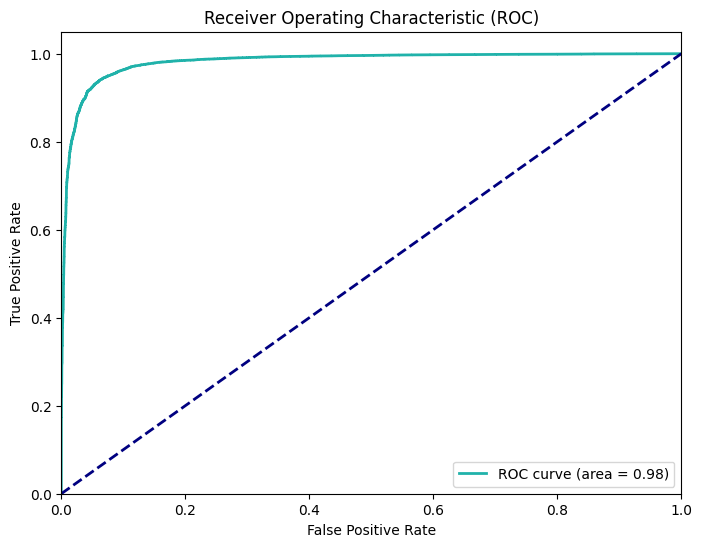

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_test_binary = np.where(y_test == 'P I F', 1, 0)
y_pred_binary = np.where(y_pred == 'P I F', 1, 0)

# Calculer le taux de faux positifs, le taux de vrais positifs et les seuils à partir des prédictions binaires
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)

# Calculer l'AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightseagreen', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve

# def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     plt.figure()
#     plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt

# # Utilisation de la fonction plot_learning_curve pour tracer la courbe d'apprentissage
# plot_learning_curve(model, "Learning Curve", X, y, ylim=(0.7, 1.01))
# plt.show()

0.9204487454397323 avec toutes les colonnes (sauf name et id) avec params : depth = 5

en supprimant les dates, mois, jours, on obtient : 9228

0.9217521222994458 , colonnes suppr : index, name // params : aucun

0.9240 sans aucun param et en ayant suppr que index, name et create job

F1 SCORE MACRO (sans aucun param) : 0.922854841138847 (juste suppr index et name)

F1 SCORE MACRO (sans aucun param) : 0.9196447775840155 (juste suppr index, name et city)

F1 SCORE MACRO (sans aucun param) : 0.9100917662983697 (juste suppr index, name bank et city)

In [23]:
df.select_dtypes(include="object")

,City,State,Bank,BankState,NAICS,UrbanRural,RevLineCr,LowDoc,MIS_Status
0,EVANSVILLE,IN,FIFTH THIRD BANK,OH,retail_trade,M,N,Y,P I F
1,NEW PARIS,IN,1ST SOURCE BANK,IN,accomodation_and_food_services,M,N,Y,P I F
2,BLOOMINGTON,IN,GRANT COUNTY STATE BANK,IN,health_care_and_social_assistance,M,N,N,P I F
3,BROKEN ARROW,OK,1ST NATL BK & TR CO OF BROKEN,OK,unknown,M,N,Y,P I F
4,ORLANDO,FL,FLORIDA BUS. DEVEL CORP,FL,unknown,M,N,N,P I F
...,...,...,...,...,...,...,...,...,...
899159,UPPER ARLINGTON,OH,JPMORGAN CHASE BANK NATL ASSOC,IL,retail_trade,M,Unknown,N,P I F
899160,COLUMBUS,OH,JPMORGAN CHASE BANK NATL ASSOC,IL,retail_trade,M,Y,N,P I F
899161,SANTA MARIA,CA,"RABOBANK, NATIONAL ASSOCIATION",CA,manufacturing,M,N,N,P I F
899162,HONOLULU,HI,BANK OF HAWAII,HI,unknown,M,N,Y,CHGOFF


In [24]:
# (df
#  .select_dtypes(include="object")
#  .map(lambda x: 'AURORA' in x)
#  .sum()
# )

In [25]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param = {"catboostclassifier__depth" : np.arange(1, 9, 0.5),
         "catboostclassifier__bootstrap" : [True, False]}

grid = GridSearchCV(model, param, cv=5)
grid.fit(X_train, y_train)

ValueError: 
All the 160 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 2303, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 2230, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6105, in _catboost._check_train_params
  File "_catboost.pyx", line 6124, in _catboost._check_train_params
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/plain_options_helper.cpp:512: Unknown option {bootstrap} with value "true"

--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 2303, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Thibaut\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 2230, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 6105, in _catboost._check_train_params
  File "_catboost.pyx", line 6124, in _catboost._check_train_params
_catboost.CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/plain_options_helper.cpp:512: Unknown option {bootstrap} with value "false"
